In [1]:
import sys
import tempfile
from pathlib import Path

import ase
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from ase.build import molecule
from ase.io.extxyz import write_xyz

from ase_hdf5 import ASEH5Trajectory, get_file_size

sys.path.insert(0, str(Path(".").parent))  # satisfy linter to import style

import style

## 1. minimial water molecule example

In [2]:
def random_water() -> ase.Atoms:
    """Generate a randomly translated and oriented water molecule."""

    atoms = molecule("H2O", vacuum=5.0)

    atoms.rotate(
        np.random.uniform(0, 360), np.random.rand(3), rotate_cell=False
    )

    atoms.translate(np.random.uniform(-5, 5, 3))

    return atoms


def test_file_sizes(units: str = "MB") -> npt.NDArray[np.floating]:
    """Gradually increase the number of molecules and check file sizes."""

    sizes = []

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)

        for n in [2**i for i in range(1, 20, 2)]:
            waters = [random_water() for _ in range(n)]

            xyz_path = temp_dir / "waters.xyz"
            h5_path = temp_dir / "waters.h5"

            write_xyz(str(xyz_path), waters)
            ASEH5Trajectory().write(waters, str(h5_path))

            xyz_size = get_file_size(xyz_path, units=units, return_float=True)
            h5_size = get_file_size(h5_path, units=units, return_float=True)

            sizes.append((n, xyz_size, h5_size))

    return np.array(sizes)

In [3]:
results = test_file_sizes()

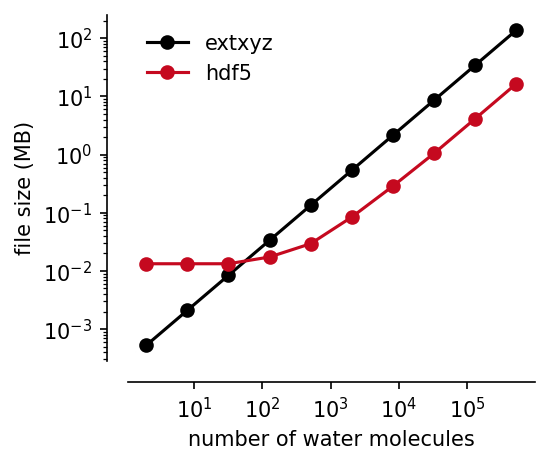

In [4]:
fig, ax = plt.subplots(dpi=150)

ax.plot(results[:, 0], results[:, 1], "-o", label="extxyz")
ax.plot(results[:, 0], results[:, 2], "-o", label="hdf5")

ax.set_xscale("log")
ax.set_xlabel("number of water molecules")

ax.set_yscale("log")
ax.set_ylabel("file size (MB)")
ax.legend()

style.move_axes(ax)

# no minor ticks.
ax.xaxis.set_minor_locator(plt.NullLocator())

plt.show()

## 2. water system with additional immutable properties

In [5]:
def random_liquid_water(n: int = 100) -> ase.Atoms:
    """Generate a random system of n water molecules."""

    atoms = ase.Atoms(cell=np.eye(3) * 20.0, pbc=True)
    for i in range(n):
        water = random_water()
        water.arrays["atom-type"] = np.array(["O1", "H1", "H1"])
        water.arrays["mol-id"] = np.array([i] * len(water))
        atoms += water

    return atoms


def test_trajectory_sizes(units: str = "MB") -> npt.NDArray[np.floating]:
    """Gradually increase the number of molecules and check file sizes."""

    sizes = []

    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)

        for n in [2**i for i in range(1, 15, 2)]:
            waters = [random_liquid_water() for _ in range(n)]

            xyz_path = temp_dir / "waters.xyz"
            h5_path = temp_dir / "waters.h5"

            write_xyz(str(xyz_path), waters)
            ASEH5Trajectory(
                immutable=["numbers", "mol-id", "atom-type"],
                mutable=["positions"],
            ).write(waters, str(h5_path))

            xyz_size = get_file_size(xyz_path, units=units, return_float=True)
            h5_size = get_file_size(h5_path, units=units, return_float=True)

            sizes.append((n, xyz_size, h5_size))

    return np.array(sizes)

In [6]:
traj_results = test_trajectory_sizes()

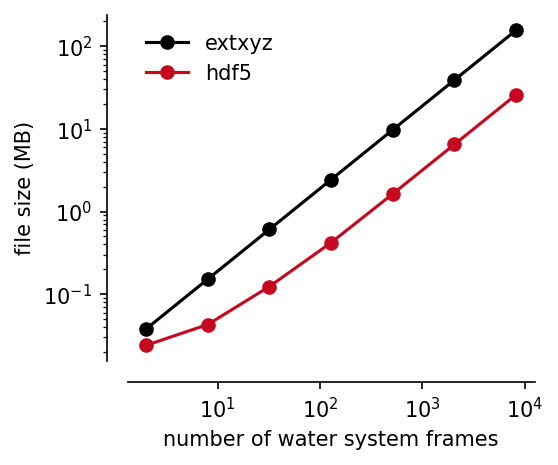

In [7]:
fig, ax = plt.subplots(dpi=150)

ax.plot(traj_results[:, 0], traj_results[:, 1], "-o", label="extxyz")
ax.plot(traj_results[:, 0], traj_results[:, 2], "-o", label="hdf5")

ax.set_xscale("log")
ax.set_xlabel("number of water system frames")
ax.xaxis.set_minor_locator(plt.NullLocator())

ax.set_yscale("log")
ax.set_ylabel("file size (MB)")

ax.legend()
style.move_axes(ax)

plt.show()

## 3. write and read

In [8]:
def atoms_are_equal(atoms1: ase.Atoms, atoms2: ase.Atoms) -> bool:
    """ Check if two ase.Atoms objects are equal. """

    _basic_properties = ["cell", "positions", "numbers"]
    _extra_properties = ["mol-id", "atom-type"]

    # all close because default writing converts to float32.
    for prop in _basic_properties:
        if not np.allclose(getattr(atoms1, prop), getattr(atoms2, prop)):
            return False
        
    for prop in _extra_properties:
        if (
            prop in atoms1.arrays 
            and prop in atoms2.arrays 
            and not np.array_equal(atoms1.arrays[prop], atoms2.arrays[prop])
        ):
            return False
        
    return True

In [9]:
system: list[ase.Atoms] = [random_liquid_water() for _ in range(10)]
system

[Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...),
 Atoms(symbols='H200O100', pbc=True, cell=[20.0, 20.0, 20.0], atom-type=..., mol-id=...)]

In [10]:
traj_writer = ASEH5Trajectory(
    immutable=["numbers", "mol-id", "atom-type"],
    mutable=["positions"],
)
traj_writer

ASEH5Trajectory(
    ensemble=NVT,
    immutable_keys=(
        atom-type,
        numbers,
        mol-id
    ),
    mutable_keys=(
        positions
    )
)

In [11]:
with tempfile.TemporaryDirectory() as temp_dir:

    temp_dir = Path(temp_dir)

    traj_writer.write(system, temp_dir / "test.h5")
    system_read = traj_writer.read(temp_dir / "test.h5")

In [12]:
for atom1, atom2 in zip(system, system_read):
    assert atoms_are_equal(atom1, atom2)